# Stock price forecasting

In [182]:
import joblib
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.offline as py
from prophet import Prophet
from itertools import product
from darts import TimeSeries
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from keras.models import load_model
from neuralprophet import NeuralProphet
from keras_tuner.tuners import RandomSearch
from darts.models import ExponentialSmoothing
from tsmoothie.smoother import ConvolutionSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
from sklearn.model_selection import TimeSeriesSplit
from utilities.evaluation import RegressionEvaluator
from darts.utils.utils import SeasonalityMode, ModelMode
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from utilities.modeling import get_best_hyperparameters, fit_model, define_preprocessing, GridSearchCV
from utilities.utils import print_best_hyperparameters, train_stacking, transform_test, create_rnn, create_lstm, create_bidirectionallstm, create_stacked_fts


py.init_notebook_mode()
pd.options.plotting.backend = "plotly"
warnings.filterwarnings(action="ignore")
pd.set_option("float_format", "{:.2f}".format)

## Load data

Usando la librería `yfinance` descargamos los datos con los cuales vamos a explorar y entrenar los modelos para hacer el pronóstico de la TRM.

In [2]:
cop = yf.Ticker(ticker="COP=X").history(start="2016-01-01", end="2021-12-31")
cop.head(n=5).append(cop.tail(n=5))

Open    High     Low   Close  Volume  Dividends  Stock Splits
Date                                                                       
2016-01-01 3138.00 3138.00 3136.70 3137.30       0          0             0
2016-01-04 3141.60 3223.00 3128.70 3154.80       0          0             0
2016-01-05 3215.00 3215.00 3153.70 3173.90       0          0             0
2016-01-06 3174.50 3256.00 3163.90 3254.00       0          0             0
2016-01-07 3163.80 3289.00 3163.80 3271.00       0          0             0
2021-12-27 3989.75 3996.25 3979.25 3989.75       0          0             0
2021-12-28 3995.08 4004.47 3956.04 3995.08       0          0             0
2021-12-29 4007.42 4024.50 4006.63 4007.42       0          0             0
2021-12-30 4036.12 4038.31 3990.58 4036.12       0          0             0
2021-12-31 4068.25 4069.83 4068.25 4068.25       0          0             0

Vamos a mirar como se ve la serie de tiempo de una manera gráfica:

In [3]:
cop.plot(y="Close")

Podemos ver que en Febrero de 2016 hubo un día donde el precio de cierre quedó registrado en el set de datos con un valor de 33.4 y viendo los valores cercanos podríamos pensar que faltó un cero y estaríamos hablando de 3340 pesos por un dólar, sin embargo, vamos a volver `NaN` este valor y lo imputaremos posteriormente con algún método.

In [4]:
idx = cop.query("Close < 100").index
cop.loc[idx, "Close"] = np.nan

Dado que el mercado solo abre de lunes a viernes, seguramente tenemos fechas en las cuales no tenemos datos y tiene sentido. Construimos un index de fechas desde el 01-01-2016 hasta 31-12-2021 en frecuencia diaria que es nuestro periodo elegido. Además todas las columnas las normalizamos colocando todos los nombres en minúsculas. Luego creamos un DataFrame que va a tener la fecha y el precio de cierre.

In [5]:
cop.reset_index(drop=False, inplace=True)
cop.columns = [col.lower() for col in cop.columns.tolist()]

data = cop[["date", "close"]]
data.head().append(data.tail())

date   close
0    2016-01-01 3137.30
1    2016-01-04 3154.80
2    2016-01-05 3173.90
3    2016-01-06 3254.00
4    2016-01-07 3271.00
1560 2021-12-27 3989.75
1561 2021-12-28 3995.08
1562 2021-12-29 4007.42
1563 2021-12-30 4036.12
1564 2021-12-31 4068.25

Para aplicar filtros de manera más sencilla convertimos la columna `date` como el index del DataFrame. Luego calculamos la cantidad de días y su respectivo porcentaje de datos missing considerando las fechas donde el mercado no presentó operaciones.

In [6]:
data.set_index(keys="date", inplace=True)

In [7]:
is_na = data.isna()

pd.DataFrame(data={"qty": is_na.sum(),
                   "perc": round(is_na.mean() * 100, 2)})

qty  perc
close    1  0.06

Dado que tenemos datos missing, utilizamos diferentes métodos para imputar el valor missing de las fechas donde hubo un error. Para eso creamos un DataFrame con el precio que en este caso serían `NaN` y otras columnas con el valor imputado con el respectivo método de imputación. Utilizamos la imputación usando los métodos:

* linear.
* nearest.
* slinear.
* quadratic.

In [8]:
methods = ["linear", "nearest", "slinear", "quadratic"]

imputation = pd.DataFrame(data["close"])
for method in methods:
    imputation[f"{method}"] = data["close"].interpolate(method=method, inplace=False)

A continuación, se muestra la tabla con los valores imputados y adicional se calcula la desviación estandard entre los métodos para ver si entre métodos difieren mucho los valores imputados.

In [9]:
idxs = imputation.index[imputation.isna()["close"]]
missings = imputation.loc[idxs]
missings["std"] = missings.std(axis=1)
missings

close  linear  nearest  slinear  quadratic   std
date                                                        
2016-02-18    NaN 3334.40  3379.40  3334.40    3326.98 23.99

Vemos que en realidad cada método en este caso imputa con valores muy similares entre si, nos quedamos con el método por default que es el `linear`.

In [10]:
data.interpolate(inplace=True)

# Statistical Models

## Exponential Smoothing

In [11]:
date_range = pd.date_range(start="1/1/2016", end="12/31/2021")

df = pd.DataFrame(data={"date": date_range})
df = pd.merge(left=df, right=cop[["date", "close"]], on=["date"], how="left")
df.set_index(keys=["date"], inplace=True)

df_train, df_test = df.loc["2016-01-01": "2021-09-30", ], df.loc["2021-10-01":"2021-12-31", ]

df_train["close"].interpolate(inplace=True)

df_test["close"].interpolate(inplace=True)

df_train.reset_index(inplace=True)

df_test.reset_index(inplace=True)

In [12]:
series = TimeSeries.from_dataframe(df=df_train, time_col="date", value_cols="close")

trends = [ModelMode.NONE, ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE]

esm_models = []

for trend in trends:
    esm_models.append(ExponentialSmoothing(trend=trend, seasonal=SeasonalityMode.NONE, random_state=42).fit(series=series))

In [13]:
for trend, model in zip(["Sin tendencia", "Aditiva", "Multiplicativa"], esm_models):
    if trend == "Sin tendencia":
        print(f"Las metricas para el ExponentialSmoothing {trend} son:")
        evaluation = RegressionEvaluator(predicted=model.predict(n=len(df_test)).data_array().data.ravel(),
                                         observed=df_test["close"])
        evaluation.print_metrics()
    else:
        print(f"Las metricas para el ExponentialSmoothing con tendencia {trend} son:")
        evaluation = RegressionEvaluator(predicted=model.predict(n=len(df_test)).data_array().data.ravel(),
                                         observed=df_test["close"])
        evaluation.print_metrics()

Las metricas para el ExponentialSmoothing Sin tendencia son:
El RMSE es: 102.9159
El MAE es: 88.4995
El MAPE es: 0.0226
Las metricas para el ExponentialSmoothing con tendencia Aditiva son:
El RMSE es: 91.0714
El MAE es: 78.8291
El MAPE es: 0.0202
Las metricas para el ExponentialSmoothing con tendencia Multiplicativa son:
El RMSE es: 88.9482
El MAE es: 77.1902
El MAPE es: 0.0198


In [14]:
joblib.dump(esm_models[2], filename="models/esm_multiplicative.joblib")

['models/esm_multiplicative.joblib']

In [15]:
df_test["esm_forecast"] = esm_models[2].predict(n=len(df_test)).data_array().data.ravel()
esm_results = df_test.copy()

In [16]:
esm_results.set_index("date", inplace=True)
esm_results.plot()

# Prophet model

Dado que para estimar el modelo Prophet debemos tener dos columnas, una que es `ds` y otra `y` que es nuestra variable objetivo. Se crea un DataFrame que tiene estas dos columnas y adicional se crea un DataFrame de entrenamiento y otro de test.

In [17]:
df = pd.DataFrame(data={"ds": data.index,
                        "y": data["close"]})

df_train, df_test = df.loc["2016-01-01": "2021-09-30", ], df.loc["2021-10-01":"2021-12-31", ]

In [18]:
param_grid = {'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
              'n_changepoints': [100, 150, 200]}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
mapes = []

for params in all_params:
    m = Prophet(**params).fit(df=df_train)
    df_cv = cross_validation(m, initial="730 days", period="365 days", horizon="90 days", parallel="dask")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

best_params = all_params[np.argmin(mapes)]

In [19]:
prophet = Prophet().fit(df=df_train)

2023-01-12 13:06:20 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-12 13:06:21 cmdstanpy DEBUG: input tempfile: /var/folders/8k/zfsqvsk94j76h4yl214d1v712bxv6z/T/tmpbn3_wqyp/54dqapz2.json
2023-01-12 13:06:21 cmdstanpy DEBUG: input tempfile: /var/folders/8k/zfsqvsk94j76h4yl214d1v712bxv6z/T/tmpbn3_wqyp/mhertsi6.json
2023-01-12 13:06:21 cmdstanpy DEBUG: idx 0
2023-01-12 13:06:21 cmdstanpy DEBUG: running CmdStan, num_threads: None
2023-01-12 13:06:21 cmdstanpy DEBUG: CmdStan args: ['/Users/stlopez/PycharmProjects/Stock-Forecasting/venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86011', 'data', 'file=/var/folders/8k/zfsqvsk94j76h4yl214d1v712bxv6z/T/tmpbn3_wqyp/54dqapz2.json', 'init=/var/folders/8k/zfsqvsk94j76h4yl214d1v712bxv6z/T/tmpbn3_wqyp/mhertsi6.json', 'output', 'file=/var/folders/8k/zfsqvsk94j76h4yl214d1v712bxv6z/T/tmpbn3_wqyp/prophet_model1svbm_1j/prophet_model-20230112130621.csv', 'm

In [20]:
joblib.dump(prophet, filename="models/prophet.joblib")

['models/prophet.joblib']

# Neural Prophet

In [21]:
neural_prophet = NeuralProphet()

metrics = neural_prophet.fit(df=df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.867% of the data.
2023-01-12 13:06:45 NP.df_utils INFO: Major frequency B corresponds to 99.867% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
2023-01-12 13:06:45 NP.df_utils INFO: Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
2023-01-12 13:06:45 NP.config INFO: Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
2023-01-12 13:06:45 NP.utils INFO: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
2023-01-12 13:06:45 NP.config INFO: Auto-set batch_size to 32
INFO - (NP.config.set_auto_bat

  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 9.48E-01
2023-01-12 13:06:46 NP.utils_torch INFO: lr-range-test results: steep: 1.00E-01, min: 9.48E-01


  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 8.07E-01
2023-01-12 13:06:46 NP.utils_torch INFO: lr-range-test results: steep: 1.00E-01, min: 8.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
2023-01-12 13:06:46 NP.forecaster INFO: lr-range-test selected learning rate: 1.00E-01
Epoch[171/171]: 100%|██████████| 171/171 [00:11<00:00, 14.34it/s, SmoothL1Loss=0.00338, MAE=76.4, RMSE=95.4, Loss=0.00264, RegLoss=0]


In [22]:
joblib.dump(neural_prophet, filename="models/neural_prophet.joblib")

['models/neural_prophet.joblib']

# ML Models

Para los algoritmos de Machine Learning, vamos a crear features autorregresivas, features a partir de la fecha y algunas ventanas móviles. Para

In [23]:
train_data, train_close = data.loc["2016-01-01": "2021-09-30", ], data.loc["2016-01-01": "2021-09-30"]
test_data, test_close = data.loc["2021-09-03":"2021-12-31", ], data.loc["2021-09-03":"2021-12-31"]

### LASSO

In [25]:
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

In [206]:
tscv = TimeSeriesSplit(n_splits=10)

alphas = [0.05, 0.1, 1.0, 10.0, 100.0]

lasso_hp, mape_lasso = get_best_hyperparameters(estimator=Lasso(random_state=42, max_iter=100000),
                                                data=train_data,
                                                close=train_close,
                                                parameters={"alpha": alphas,
                                                            "fit_intercept": [True, False]},
                                                cv=tscv,
                                                lags_max_candidates=[5, 10, 15, 20],
                                                periods_candidates=[[5], [10], [5, 10, 15]])

print_best_hyperparameters(hyperparameters=lasso_hp)

lasso_preprocessing, lasso = fit_model(estimator=Lasso(alpha=lasso_hp["alpha"],
                                                       fit_intercept=lasso_hp["fit_intercept"]),
                                       lag=lasso_hp["lag_max"],
                                       period=lasso_hp["periods"],
                                       data=train_data, close=train_close)

alpha: 100.0
fit_intercept: True
lag_max: 5
periods: [5]


In [27]:
joblib.dump(lasso_preprocessing, filename="preprocessing/lasso_preprocessing.joblib")
joblib.dump(lasso, filename="models/lasso.joblib")

['models/lasso.joblib']

### Ridge

In [28]:
ridge_hp, mape_ridge = get_best_hyperparameters(estimator=Ridge(random_state=42),
                                                data=train_data,
                                                close=train_close,
                                                parameters={"alpha": alphas,
                                                            "fit_intercept": [True, False]},
                                                cv=tscv,
                                                lags_max_candidates=[5, 10, 15, 20],
                                                periods_candidates=[[5], [10], [5, 10, 15]])

print_best_hyperparameters(hyperparameters=ridge_hp)

ridge_preprocessing, ridge = fit_model(estimator=Ridge(alpha=ridge_hp["alpha"],
                                                       fit_intercept=ridge_hp["fit_intercept"],
                                                       random_state=42),
                                       lag=ridge_hp["lag_max"],
                                       period=ridge_hp["periods"],
                                       data=train_data, close=train_close)

alpha: 100.0
fit_intercept: True
lag_max: 5
periods: [5]


In [29]:
joblib.dump(ridge_preprocessing, filename="preprocessing/ridge_preprocessing.joblib")
joblib.dump(ridge, filename="models/ridge.joblib")

['models/ridge.joblib']

### Gradient Boosting

In [30]:
warnings.filterwarnings(action="ignore", category=DataConversionWarning)

In [205]:
gbm_hp, mape_gbm = get_best_hyperparameters(estimator=GradientBoostingRegressor(random_state=42),
                                            data=train_data,
                                            close=train_close,
                                            parameters={"n_estimators": [100, 150, 200],
                                                        "max_depth": [3, 5, 7],
                                                        "max_leaf_nodes": [2, 5, 10],
                                                        "ccp_alpha": [0.05, 0.5, 0.9]},
                                            cv=tscv,
                                            lags_max_candidates=[5, 10, 15, 20],
                                            periods_candidates=[[5], [10], [5, 10, 15]])

print_best_hyperparameters(hyperparameters=gbm_hp)

gbm_preprocessing, gbm = fit_model(estimator=GradientBoostingRegressor(n_estimators=gbm_hp["n_estimators"],
                                                                       max_depth=gbm_hp["max_depth"],
                                                                       max_leaf_nodes=gbm_hp["max_leaf_nodes"],
                                                                       ccp_alpha=gbm_hp["ccp_alpha"],
                                                                       random_state=42),
                                   lag=gbm_hp["lag_max"],
                                   period=gbm_hp["periods"],
                                   data=train_data, close=train_close)

ccp_alpha: 0.9
max_depth: 5
max_leaf_nodes: 5
n_estimators: 150
lag_max: 10
periods: [5]


In [32]:
joblib.dump(gbm_preprocessing, filename="preprocessing/gbm_preprocessing.joblib")
joblib.dump(gbm, filename="models/gbmodel.joblib")

['models/gbmodel.joblib']

### XGBoost

In [33]:
xgb_hp, mape_xgb = get_best_hyperparameters(estimator=XGBRegressor(seed=42),
                                  data=train_data,
                                  close=train_close,
                                  parameters={"eta": [0.1, 0.2],
                                              "max_depth": [3, 5, 7],
                                              "n_estimators": [100, 150, 200],
                                              "colsample_bytree": [0.5, 0.8, 1.0]},
                                  cv=tscv,
                                  lags_max_candidates=[5, 10, 15, 20],
                                  periods_candidates=[[5], [10], [5, 10, 15]])

print_best_hyperparameters(hyperparameters=xgb_hp)

xgb_preprocessing, xgb = fit_model(estimator=XGBRegressor(eta=xgb_hp["eta"],
                                                          max_depth=xgb_hp["max_depth"],
                                                          n_estimators=xgb_hp["n_estimators"],
                                                          colsample_bytree=xgb_hp["colsample_bytree"]),
                                   lag=xgb_hp["lag_max"],
                                   period=xgb_hp["periods"],
                                   data=train_data, close=train_close)

colsample_bytree: 1.0
eta: 0.1
max_depth: 3
n_estimators: 200
lag_max: 5
periods: [5, 10, 15]


In [34]:
joblib.dump(xgb_preprocessing, filename="preprocessing/xgb_preprocessing.joblib")
joblib.dump(xgb, filename="models/xgboost.joblib")

['models/xgboost.joblib']

In [35]:
ml_mapes = {key: value for key, value in zip(["LASSO", "Ridge", "GBoosting", "XGBoost"],
                                             [mape_lasso, mape_ridge, mape_gbm, mape_xgb])}

# Ensemble ML Models

In [36]:
estimators = [("Ridge", Ridge(alpha=ridge_hp["fit_intercept"],
                              fit_intercept=ridge_hp["fit_intercept"])),
              ("Lasso", Lasso(alpha=lasso_hp["alpha"],
                              fit_intercept=lasso_hp["fit_intercept"],
                              max_iter=100000)),
              ("GBM", GradientBoostingRegressor(n_estimators=gbm_hp["n_estimators"],
                                                max_depth=gbm_hp["max_depth"],
                                                max_leaf_nodes=gbm_hp["max_leaf_nodes"],
                                                ccp_alpha=gbm_hp["ccp_alpha"],
                                                random_state=42)),
              ("XGB", XGBRegressor(eta=xgb_hp["eta"],
                                   max_depth=xgb_hp["max_depth"],
                                   n_estimators=xgb_hp["n_estimators"],
                                   colsample_bytree=xgb_hp["colsample_bytree"]))]

In [37]:
preprocessing = define_preprocessing(lags=10, periods=[5, 10, 15])

train = preprocessing.fit_transform(train_data, train_close)
train_target = train_close.loc[train.index.tolist()]

ensemble = VotingRegressor(estimators=estimators, n_jobs=-1).fit(train, train_target)

In [44]:
joblib.dump(preprocessing, filename="preprocessing/ensemble_preprocessing.joblib")
joblib.dump(ensemble, filename="models/ensemble.joblib")

['models/ensemble.joblib']

# Stacking ML Models

In [72]:
test = preprocessing.transform(test_data).loc["2021-10-01":"2021-12-31", :]
test_target = test_close.loc[test.index.tolist()]

In [73]:
base_models = [model for name, model in estimators]

In [74]:
train.reset_index(drop=True, inplace=True)

train_target.index = train.index

In [75]:
X, trained_ml_models = train_stacking(data=train, close=train_target, base_models=base_models)

In [76]:
X_train = X[[f"{model.__class__.__name__}_forecast" for model in base_models]].dropna()

In [77]:
X_test = transform_test(data=test, trained_models=trained_ml_models)[[f"{model.__class__.__name__}_forecast" for model in base_models]]

In [ ]:
alphas = [0.01, 0.05, 0.1, 1.0, 10.0, 100.0]

params = {"alpha": alphas,
          "l1_ratio": [0, 0.2, 0.4, 0.5, 0.8, 1.0],
          "fit_intercept": [True, False]}

elastic_net = GridSearchCV(estimator=ElasticNet(random_state=42, max_iter=1000000),
                           param_grid=params, scoring="neg_mean_absolute_percentage_error", cv=5, n_jobs=-1).fit(X_train, train_target.loc[X_train.index.tolist()])

In [79]:
print_best_hyperparameters(elastic_net.best_params_)

alpha: 10.0
fit_intercept: True
l1_ratio: 1.0


# Stacking DL Models

In [81]:
rnn_tuner = RandomSearch(hypermodel=create_rnn,
                         objective="val_mse",
                         max_trials=5,
                         seed=42,
                         directory="S-RNN")

lstm_tuner = RandomSearch(hypermodel=create_lstm,
                          objective="val_mse",
                          max_trials=5,
                          seed=42,
                          directory="S-LSTM")

bilstm_tuner = RandomSearch(hypermodel=create_bidirectionallstm,
                          objective="val_mse",
                          max_trials=5,
                          seed=42,
                          directory="S-BILSTM")

2023-01-12 13:53:42.881267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
base_tuners = [rnn_tuner, lstm_tuner, bilstm_tuner]

X_train_dl = pd.DataFrame()
dl_trained_models = {}

for name, tuner in zip(["RNN", "LSTM", "BidirectionalLSTM"],
                       base_tuners):
    preds, models = create_stacked_fts(estimator=tuner, data=train, close=train_target)
    X_train_dl[f"{name}_forecast"] = preds
    dl_trained_models[f"{name}_forecast"] = models

X_train_dl.dropna(inplace=True)

Trial 5 Complete [00h 10m 27s]
val_mse: 393752.6875

Best val_mse So Far: 121018.265625
Total elapsed time: 00h 20m 25s
INFO:tensorflow:Oracle triggered exit


2023-01-12 15:55:42 tensorflow INFO: Oracle triggered exit


In [83]:
X_test_dl = pd.DataFrame(index=test.index)

for name, models in dl_trained_models.items():
    preds = [model.predict(test.values.reshape(-1, 1, 34)) for model in models]
    avg = np.array([sum(x) for x in zip(*preds)]) / len(models)
    X_test_dl[f"{name}_forecast"] = avg

3/3 [==============================] - 0s 3ms/step


In [ ]:
elastic_net_dl = GridSearchCV(estimator=ElasticNet(random_state=42, max_iter=1000000),
                              param_grid=params,
                              scoring="neg_mean_absolute_percentage_error",
                              cv=5, n_jobs=-1).fit(X_train_dl.dropna(), train_target.loc[X_train_dl.index.tolist()])

In [99]:
print_best_hyperparameters(elastic_net_dl.best_params_)

alpha: 100.0
fit_intercept: False
l1_ratio: 1.0


# Stackin ML + DL

In [98]:
final_stacking = GridSearchCV(estimator=ElasticNet(random_state=42, max_iter=1000000),
                              param_grid=params,
                              scoring="neg_mean_absolute_percentage_error",
                              cv=5, n_jobs=-1).fit(X_train.join(X_train_dl), train_target.reset_index(drop=True).loc[X_train_dl.index.tolist()])

/Users/stlopez/PycharmProjects/Stock-Forecasting/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.248e+04, tolerance: 1.230e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/stlopez/PycharmProjects/Stock-Forecasting/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.270e+04, tolerance: 1.109e+04 Linear regression models with null weight for the l1 regularization term are

In [100]:
print_best_hyperparameters(final_stacking.best_params_)

alpha: 10.0
fit_intercept: True
l1_ratio: 1.0


# DL Models

## RNN

In [85]:
preprocessing = define_preprocessing(lags=10, periods=[5, 10, 15])

train = preprocessing.fit_transform(train_data, train_close)
train_target = train_close.loc[train.index.tolist()]

In [86]:
rnn = load_model(filepath="models/rnn.h5")
rnn.summary()

2023-01-12 15:56:38 tensorflow WARNING: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            20864     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 64)             12352     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               24704     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 58,049
Trainable params: 58,049
Non-traina

## LSTM

In [87]:
lstm = load_model(filepath="models/lstm.h5")
lstm.summary()

2023-01-12 15:56:39 tensorflow WARNING: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             25344     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 255,873
Trainable params: 255,873
Non-trai

## BidirectionalLSTM

In [88]:
bi_lstm = load_model(filepath="models/bilstm.h5")

# Evaluation

In [104]:
numeric_features = [f"close_{int(i)}" for i in range(1, 11)] + [f"sma_{int(i)}" for i in [5, 10, 15]]

In [105]:
scaler = joblib.load(filename="preprocessing/scaler_neuralnetworks.joblib")

test_data_dl = preprocessing.transform(test_data).loc["2021-10-01":]
test_data_dl.loc[:, numeric_features] = scaler.transform(test_data_dl[numeric_features])

In [106]:
train_data_dl = preprocessing.transform(train_data)
train_data_dl.loc[:, numeric_features] = scaler.transform(train_data_dl[numeric_features])

In [136]:
models = [("Prophet", None, prophet), ("NeuralProphet", None, neural_prophet),
          ("Ridge", ridge_preprocessing, ridge), ("LASSO", lasso_preprocessing, lasso),
          ("GBoosting", gbm_preprocessing, gbm), ("XGBoost", xgb_preprocessing, xgb),
          ("Ensemble", preprocessing, ensemble), ("Stacking ML", None, elastic_net),
          ("Stacking DL", None, elastic_net_dl), ("Stacking ML-DL", None, final_stacking),
          ("RNN", preprocessing, rnn), ("LSTM", preprocessing, lstm), ("BidirectionalLSTM", preprocessing, bi_lstm)]

idxs = test_target.shape[0]

metrics = {}

for name, prepro, model in models:
    print(f"Las metricas para el modelo {name} son:")
    if name == "Prophet":
        evaluation = RegressionEvaluator(predicted=model.predict(df=df_test)["yhat"],
                                         observed=test_target)
    elif name == "NeuralProphet":
        evaluation = RegressionEvaluator(predicted=model.predict(df=df_test)["yhat1"],
                                         observed=test_target)
    elif name in ["RNN", "LSTM", "GRU", "BidirectionalLSTM"]:
        predicted = model.predict(test_data_dl.values.reshape(-1, 1, 34))
        evaluation = RegressionEvaluator(predicted=predicted,
                                         observed=test_target.iloc[idxs - predicted.shape[0]:])
    elif name in [f"Stacking {i}" for i in ["ML", "DL", "ML-DL"]]:
        if name == "Stacking ML":
            evaluation = RegressionEvaluator(predicted=model.predict(X_test),
                                             observed=test_target)
        elif name == "Stacking DL":
            evaluation = RegressionEvaluator(predicted=model.predict(X_test_dl),
                                             observed=test_target)
        else:
            evaluation = RegressionEvaluator(predicted=model.predict(X_test.join(X_test_dl)),
                                             observed=test_target)
    else:
        if name == "Ridge":
            predicted = model.predict(prepro.transform(test_data).loc["2021-10-01":"2021-12-31", :].iloc[:, 2:])
            evaluation = RegressionEvaluator(predicted=predicted,
                                         observed=test_target.iloc[idxs - predicted.shape[0]:])
        else:
            predicted = model.predict(prepro.transform(test_data).loc["2021-10-01":"2021-12-31", :])
            evaluation = RegressionEvaluator(predicted=predicted,
                                         observed=test_target.iloc[idxs - predicted.shape[0]:])
    metrics[f"{name}"] = [evaluation.calculate_metrics()["rmse"], evaluation.calculate_metrics()["mae"], evaluation.calculate_metrics()["mape"]]
    evaluation.print_metrics()
    print("--" * 30)

Las metricas para el modelo Prophet son:


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 98.485% of the data.
2023-01-12 17:04:16 NP.df_utils INFO: Major frequency B corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
2023-01-12 17:04:16 NP.df_utils INFO: Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 98.485% of the data.
2023-01-12 17:04:16 NP.df_utils INFO: Major frequency B corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
2023-01-12 17:04:16 NP.df_utils INFO: Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2023-01-12 17:04:16 NP.df_utils INFO: Returning df with no ID column


El RMSE es: 155.9621
El MAE es: 123.7403
El MAPE es: 0.0314
------------------------------------------------------------
Las metricas para el modelo NeuralProphet son:
El RMSE es: 262.2837
El MAE es: 208.3711
El MAPE es: 0.0528
------------------------------------------------------------
Las metricas para el modelo Ridge son:
El RMSE es: 15.3113
El MAE es: 12.0159
El MAPE es: 0.0031
------------------------------------------------------------
Las metricas para el modelo LASSO son:
El RMSE es: 19.6363
El MAE es: 14.94
El MAPE es: 0.0038
------------------------------------------------------------
Las metricas para el modelo GBoosting son:
El RMSE es: 28.474
El MAE es: 21.6615
El MAPE es: 0.0055
------------------------------------------------------------
Las metricas para el modelo XGBoost son:
El RMSE es: 30.2037
El MAE es: 22.9154
El MAPE es: 0.0059
------------------------------------------------------------
Las metricas para el modelo Ensemble son:
El RMSE es: 14.4197
El MAE es: 11.

# Metrics

In [137]:
metrics = pd.DataFrame(metrics).T.rename(columns={0: "RMSE",
                                                  1: "MAE",
                                                  2: "MAPE"})
metrics["MAPE"] = metrics["MAPE"] * 100
metrics

RMSE    MAE  MAPE
Prophet           155.96 123.74  3.14
NeuralProphet     262.28 208.37  5.28
Ridge              15.31  12.02  0.31
LASSO              19.64  14.94  0.38
GBoosting          28.47  21.66  0.55
XGBoost            30.20  22.92  0.59
Ensemble           14.42  11.05  0.28
Stacking ML         0.56   0.43  0.01
Stacking DL        45.20  37.24  0.96
Stacking ML-DL      0.55   0.42  0.01
RNN                33.38  24.43  0.62
LSTM               34.43  26.63  0.69
BidirectionalLSTM  42.58  35.61  0.92

In [138]:
train_forecast = []
test_forecast = []

for name, prepro, model in models:
    if name == "Prophet":
        train_forecast.append(pd.DataFrame(data={f"{name}_forecast": model.predict(df=df_train)["yhat"].tolist()},
                                           index=df_train.index))
    elif name == "NeuralProphet":
        train_forecast.append(pd.DataFrame(data={f"{name}_forecast": model.predict(df=df_train)["yhat1"].tolist()},
                                           index=df_train.index))
    elif name in ["RNN", "LSTM", "BidirectionalLSTM"]:
        train_forecast.append(pd.DataFrame(data={f"{name}_forecast": model.predict(train_data_dl.values.reshape(-1, 1, 34)).ravel()},
                                           index=train_data_dl.index))
    elif name in [f"Stacking {i}" for i in ["ML", "DL", "ML-DL"]]:
        if name == "Stacking ML":
            n = name.split()
            idx = train_target.shape[0]
            forecast = model.predict(X_train)
            train_forecast.append(pd.DataFrame(data={f"{n[0]}_{n[1].lower()}_forecast": forecast},
                                               index=train_target.index[idx - forecast.shape[0]:]))
        elif name == "Stacking DL":
            n = name.split()
            idx = train_target.shape[0]
            forecast = model.predict(X_train_dl)
            train_forecast.append(pd.DataFrame(data={f"{n[0]}_{n[1].lower()}_forecast": forecast},
                                               index=train_target.index[idx - forecast.shape[0]:]))
        else:
            idx = train_target.shape[0]
            forecast = model.predict(X_train.join(X_train_dl))
            train_forecast.append(pd.DataFrame(data={f"Stacking_ml_dl_forecast": forecast},
                                               index=train_target.index[idx - forecast.shape[0]:]))
    else:
        if name == "Ridge":
            idx = train_close.shape[0]
            forecast = model.predict(prepro.transform(train_data).iloc[:, 2:]).ravel()
            train_forecast.append(pd.DataFrame(data={f"{name}_forecast": forecast}, index=train_close.index[idx - forecast.shape[0]:]))
        else:
            idx = train_close.shape[0]
            forecast = model.predict(prepro.transform(train_data)).ravel()
            train_forecast.append(pd.DataFrame(data={f"{name}_forecast": forecast}, index=train_close.index[idx - forecast.shape[0]:]))

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.867% of the data.
2023-01-12 17:04:45 NP.df_utils INFO: Major frequency B corresponds to 99.867% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
2023-01-12 17:04:45 NP.df_utils INFO: Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.867% of the data.
2023-01-12 17:04:45 NP.df_utils INFO: Major frequency B corresponds to 99.867% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
2023-01-12 17:04:45 NP.df_utils INFO: Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2023-01-12 17:04:45 NP.df_utils INFO: Returning df with no ID column


47/47 [==============================] - 0s 2ms/step


In [139]:
for name, prepro, model in models:
    if name == "Prophet":
        test_forecast.append(pd.DataFrame(data={f"{name}_forecast": model.predict(df=df_test)["yhat"].tolist()},
                                           index=df_test.index))
    elif name == "NeuralProphet":
        test_forecast.append(pd.DataFrame(data={f"{name}_forecast": model.predict(df=df_test)["yhat1"].tolist()},
                                           index=df_test.index))
    elif name in ["RNN", "LSTM", "BidirectionalLSTM"]:
        test_forecast.append(pd.DataFrame(data={f"{name}_forecast": model.predict(test_data_dl.values.reshape(-1, 1, 34)).ravel()},
                                           index=test_data_dl.index))
    elif name in [f"Stacking {i}" for i in ["ML", "DL", "ML-DL"]]:
        if name == "Stacking ML":
            n = name.split()
            test_forecast.append(pd.DataFrame(data={f"{n[0]}_{n[1].lower()}_forecast": model.predict(X_test)},
                                               index=test_target.index))
        elif name == "Stacking DL":
            n = name.split()
            test_forecast.append(pd.DataFrame(data={f"{n[0]}_{n[1].lower()}_forecast": model.predict(X_test_dl)},
                                               index=test_target.index))
        else:
            test_forecast.append(pd.DataFrame(data={f"Stacking_ml_dl_forecast": model.predict(X_test.join(X_test_dl))},
                                               index=test_target.index))
    else:
        if name == "Ridge":
            idx = test_target.shape[0]
            forecast = model.predict(prepro.transform(test_data).loc["2021-10-01":"2021-12-31", :].iloc[:, 2:]).ravel()
            test_forecast.append(pd.DataFrame(data={f"{name}_forecast": forecast}, index=test_target.index[idx - forecast.shape[0]:]))
        else:
            idx = test_target.shape[0]
            forecast = model.predict(prepro.transform(test_data).loc["2021-10-01":"2021-12-31", :]).ravel()
            test_forecast.append(pd.DataFrame(data={f"{name}_forecast": forecast}, index=test_target.index[idx - forecast.shape[0]:]))

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 98.485% of the data.
2023-01-12 17:04:51 NP.df_utils INFO: Major frequency B corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
2023-01-12 17:04:51 NP.df_utils INFO: Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 98.485% of the data.
2023-01-12 17:04:51 NP.df_utils INFO: Major frequency B corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
2023-01-12 17:04:51 NP.df_utils INFO: Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
2023-01-12 17:04:51 NP.df_utils INFO: Returning df with no ID column


3/3 [==============================] - 0s 3ms/step


In [140]:
train = pd.concat(objs=train_forecast, axis=1).join(train_close)

test = pd.concat(objs=test_forecast, axis=1).join(test_target)

In [145]:
test["ESM_forecast"] = esm_results.loc[test.index.tolist(), "esm_forecast"]

In [146]:
test.plot()

In [153]:
pd.concat(objs=[train, test.drop(columns=["ESM_forecast"])], axis=0).plot()

# Ensambles

In [154]:
final_output = test.copy()
final_output

Prophet_forecast  NeuralProphet_forecast  Ridge_forecast  \
date                                                                   
2021-10-01           3812.91                 3737.51         3821.52   
2021-10-04           3814.12                 3732.55         3803.39   
2021-10-05           3825.53                 3743.07         3790.19   
2021-10-06           3824.61                 3739.99         3780.97   
2021-10-07           3823.92                 3738.76         3781.07   
...                      ...                     ...             ...   
2021-12-27           3699.24                 3537.32         3990.60   
2021-12-28           3706.01                 3545.60         3995.43   
2021-12-29           3700.42                 3540.41         3996.50   
2021-12-30           3695.04                 3537.20         4013.53   
2021-12-31           3688.01                 3532.30         4044.45   

            LASSO_forecast  GBoosting_forecast  XGBoost_forecast  \
date                                                               
2021-10-01         3827.25             3836.60           3834.45   
2021-10-04         3806.84             3797.67           3795.04   
2021-10-05         3793.98             3796.80           3795.06   
2021-10-06         3787.60             3798.36           3796.66   
2021-10-07         3782.84             3798.36           3802.14   
...                    ...                 ...               ...   
2021-12-27         3993.07             3972.69           3972.44   
2021-12-28         3995.51             3970.80           3958.50   
2021-12-29         3997.34             3961.25           3951.75   
2021-12-30         4014.91             3969.61           3966.72   
2021-12-31         4040.63             4009.68           3990.89   

            Ensemble_forecast  Stacking_ml_forecast  Stacking_dl_forecast  \
date                                                                        
2021-10-01            3822.49               3808.81               3846.95   
2021-10-04            3794.40               3788.49               3844.29   
2021-10-05            3794.28               3788.13               3839.43   
2021-10-06            3791.24               3781.53               3832.79   
2021-10-07            3792.30               3785.25               3826.80   
...                       ...                   ...                   ...   
2021-12-27            3984.12               3989.63               3988.17   
2021-12-28            3985.95               3994.87               4000.83   
2021-12-29            3983.93               4006.77               4007.74   
2021-12-30            4005.25               4035.10               4012.50   
2021-12-31            4037.49               4067.09               4019.92   

            Stacking_ml_dl_forecast  RNN_forecast  LSTM_forecast  \
date                                                               
2021-10-01                  3808.77       3791.35        3845.79   
2021-10-04                  3788.45       3803.18        3834.31   
2021-10-05                  3788.11       3796.55        3841.48   
2021-10-06                  3781.51       3769.74        3821.45   
2021-10-07                  3785.23       3773.96        3795.96   
...                             ...           ...            ...   
2021-12-27                  3989.61       3972.80        3983.24   
2021-12-28                  3994.85       3976.29        4000.52   
2021-12-29                  4006.77       3956.43        3984.21   
2021-12-30                  4035.11       3972.80        3965.29   
2021-12-31                  4067.11       3973.34        3992.62   

            BidirectionalLSTM_forecast   close  ESM_forecast  
date                                                          
2021-10-01                     3854.58 3808.62       3834.73  
2021-10-04                     3838.78 3788.25       3835.85  
2021-10-05                     3867.74 3788.25     

In [156]:
ml_forecasters = ["Ridge_forecast", "LASSO_forecast", "GBoosting_forecast", "XGBoost_forecast"]
dl_forecasters = ["RNN_forecast", "LSTM_forecast", "BidirectionalLSTM_forecast"]

# Ensembles (Mean)

In [158]:
final_output["Ensemble_ml_forecast"] = final_output[ml_forecasters].mean(axis=1)
final_output["Ensemble_dl_forecast"] = final_output[dl_forecasters].mean(axis=1)
final_output["Ensemble_ml_dl_forecast"] = final_output[ml_forecasters + dl_forecasters].mean(axis=1)

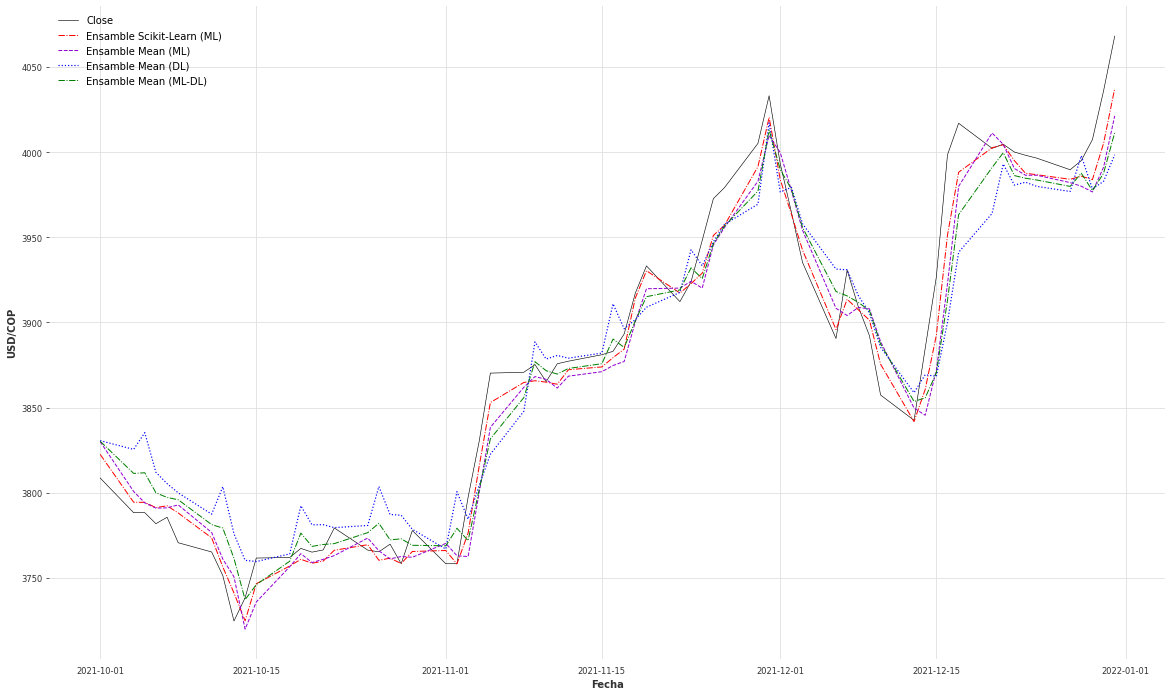

In [179]:
plt.figure(figsize=(20, 12))
plt.plot(final_output.index, final_output['close'], color = 'black', linewidth=0.6, label = 'Close')
plt.plot(final_output.index, final_output['Ensemble_forecast'], color = 'red', linewidth=1, linestyle = '-.', label = 'Ensamble Scikit-Learn (ML)')
plt.plot(final_output.index, final_output['Ensemble_ml_forecast'], color = 'darkviolet', linewidth=1, linestyle = '--', label = 'Ensamble Mean (ML)')
plt.plot(final_output.index, final_output['Ensemble_dl_forecast'], color = 'blue', linewidth=1.2, linestyle = ':', label = 'Ensamble Mean (DL)')
plt.plot(final_output.index, final_output['Ensemble_ml_dl_forecast'], color = 'green', linewidth=1, linestyle = '-.', label = 'Ensamble Mean (ML-DL)')
plt.xlabel('Fecha')
plt.ylabel('USD/COP')
plt.legend()

# Ensembles (Weighted)

In [171]:
dl_metrics = [RegressionEvaluator(predicted=model.predict(train_data_dl.values.reshape(-1, 1, 34)),
                                  observed=train_close.loc[train_data_dl.index]).calculate_metrics()["mape"] for model in [rnn, lstm, bi_lstm]]
dl_mapes = {key: 1 - value for key, value in zip(["RNN", "LSTM", "BidirectionalLSTM"], dl_metrics)}
ml_mapes = {key: 1 - value for key, value in ml_mapes.items()}

47/47 [==============================] - 0s 2ms/step


In [174]:
dl_ml_mapes = [i for i in ml_mapes.values()] + [i for i in dl_mapes.values()]

In [175]:
final_output['Weighted_ml_forecast'] = np.average(final_output[ml_forecasters], weights= [i for i in ml_mapes.values()], axis=1)
final_output['Weighted_dl_forecast'] = np.average(final_output[dl_forecasters], weights= [i for i in dl_mapes.values()], axis=1)
final_output['Weighted_ml_dl_forecast'] = np.average(final_output[ml_forecasters + dl_forecasters], weights= dl_ml_mapes, axis=1)

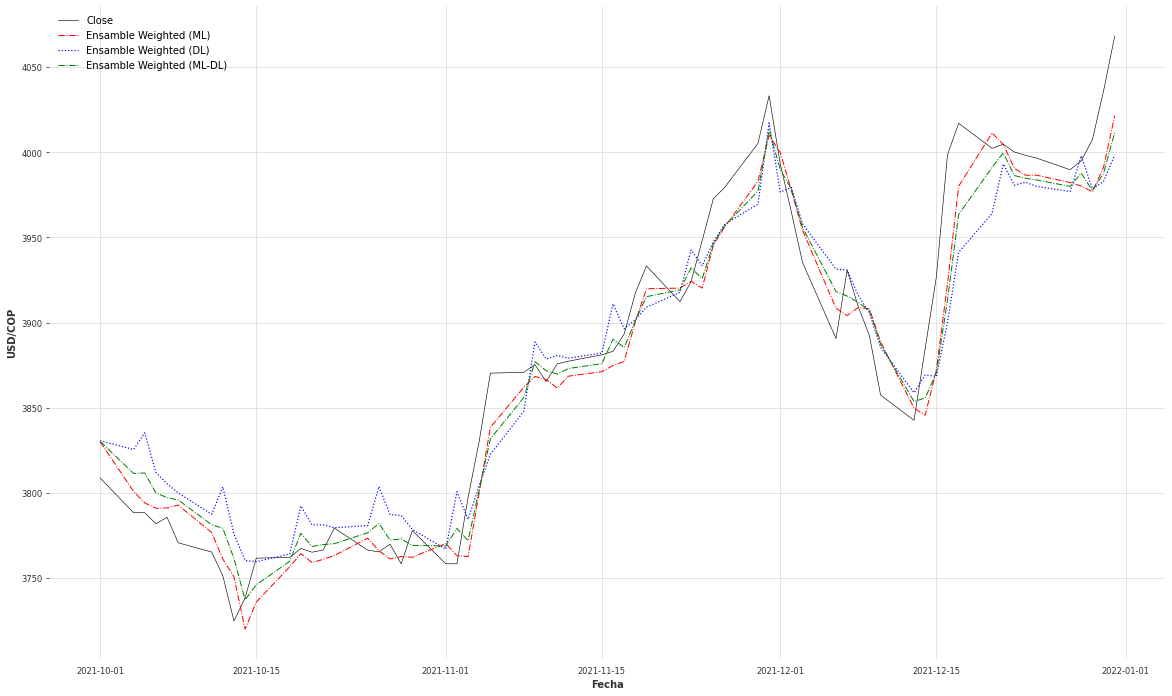

In [180]:
plt.figure(figsize=(20, 12))
plt.plot(final_output.index, final_output['close'], color = 'black', linewidth=0.6, label = 'Close')
plt.plot(final_output.index, final_output['Weighted_ml_forecast'], color = 'red', linewidth=1, linestyle = '-.', label = 'Ensamble Weighted (ML)')
plt.plot(final_output.index, final_output['Weighted_dl_forecast'], color = 'blue', linewidth=1.2, linestyle = ':', label = 'Ensamble Weighted (DL)')
plt.plot(final_output.index, final_output['Weighted_ml_dl_forecast'], color = 'green', linewidth=1, linestyle = '-.', label = 'Ensamble Weighted (ML-DL)')
plt.xlabel('Fecha')
plt.ylabel('USD/COP')
plt.legend()

# Stacking

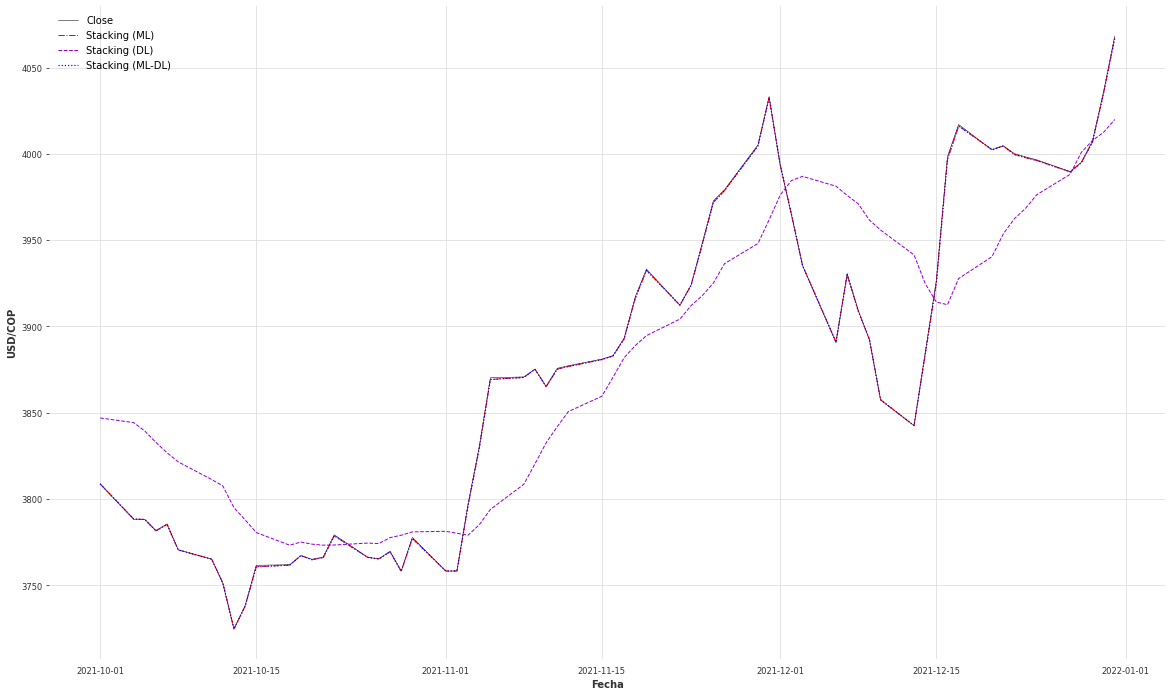

In [181]:
plt.figure(figsize=(20, 12))
plt.plot(final_output.index, final_output['close'], color = 'black', linewidth=0.5, label = 'Close')
plt.plot(final_output.index, final_output['Stacking_ml_forecast'], color = 'red', linewidth=1, linestyle = '-.', label = 'Stacking (ML)')
plt.plot(final_output.index, final_output['Stacking_dl_forecast'], color = 'darkviolet', linewidth=1, linestyle = '--', label = 'Stacking (DL)')
plt.plot(final_output.index, final_output['Stacking_ml_dl_forecast'], color = 'blue', linewidth=1.2, linestyle = ':', label = 'Stacking (ML-DL)')
plt.xlabel('Fecha')
plt.ylabel('USD/COP')
plt.legend()

# Intervals prediction

In [186]:
best_forecast = final_output[['close','Ensemble_forecast','Stacking_ml_forecast']]

In [187]:
df = final_output["Ensemble_forecast"].T

bts = BootstrappingWrapper(ConvolutionSmoother(window_len=3, window_type="ones"),
                           bootstrap_type="mbb", block_length=10)

bts_samples = bts.sample(data=df, n_samples=10000)

In [190]:
means = [np.mean(bts_samples[:, i]) for i in range(bts_samples.shape[1])]
std = [np.std(bts_samples[:, i]) for i in range(bts_samples.shape[1])]

best_forecast["LI"] = [m - 3 * s for m, s in zip(means, std)]
best_forecast["LS"] = [m + 3 * s for m, s in zip(means, std)]

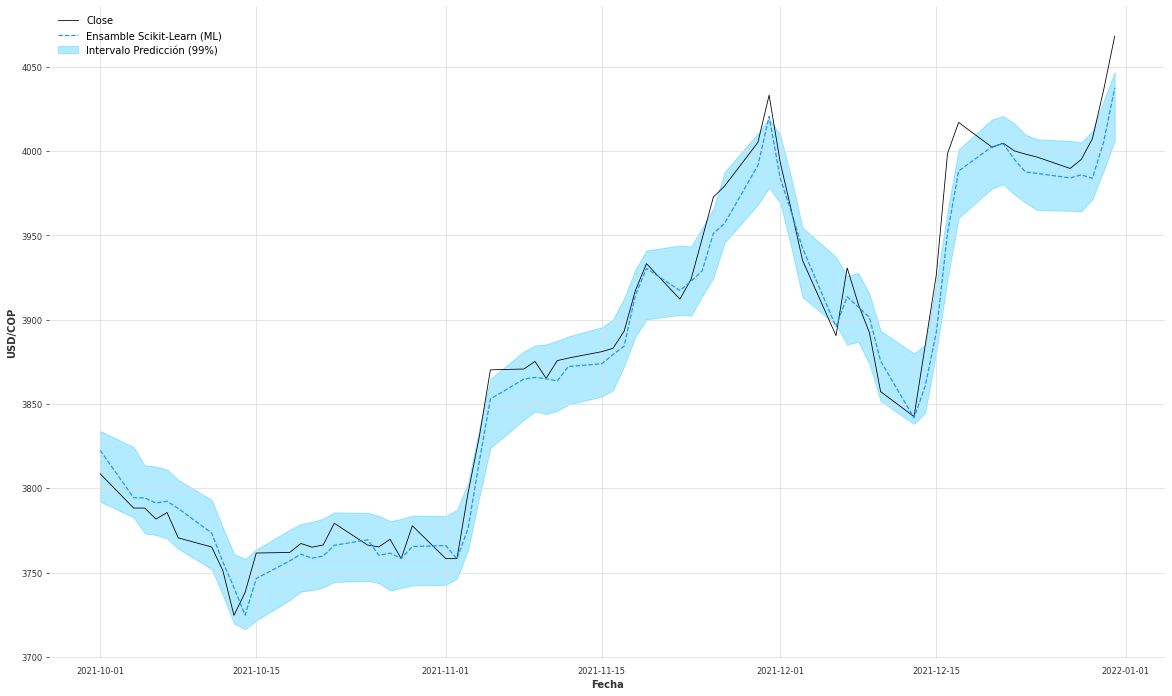

In [191]:
plt.figure(figsize=(20, 12))
plt.plot(best_forecast.index, best_forecast['close'], color = 'black', linewidth=0.8, label = 'Close')
plt.plot(best_forecast.index, best_forecast['Ensemble_forecast'], color = 'dodgerblue', linewidth=1.2, linestyle = 'dashed', label = 'Ensamble Scikit-Learn (ML)')
plt.fill_between(best_forecast.index, best_forecast['LI'], best_forecast['LS'], color = 'deepskyblue', alpha = 0.3, label = 'Intervalo Predicción (99%)')
plt.xlabel('Fecha')
plt.ylabel('USD/COP')
plt.legend()

In [193]:
best_forecast["LI"] = [np.quantile(bts_samples[:, i], q=0.025) for i in range(bts_samples.shape[1])]
best_forecast["LS"] = [np.quantile(bts_samples[:, i], q=0.975) for i in range(bts_samples.shape[1])]

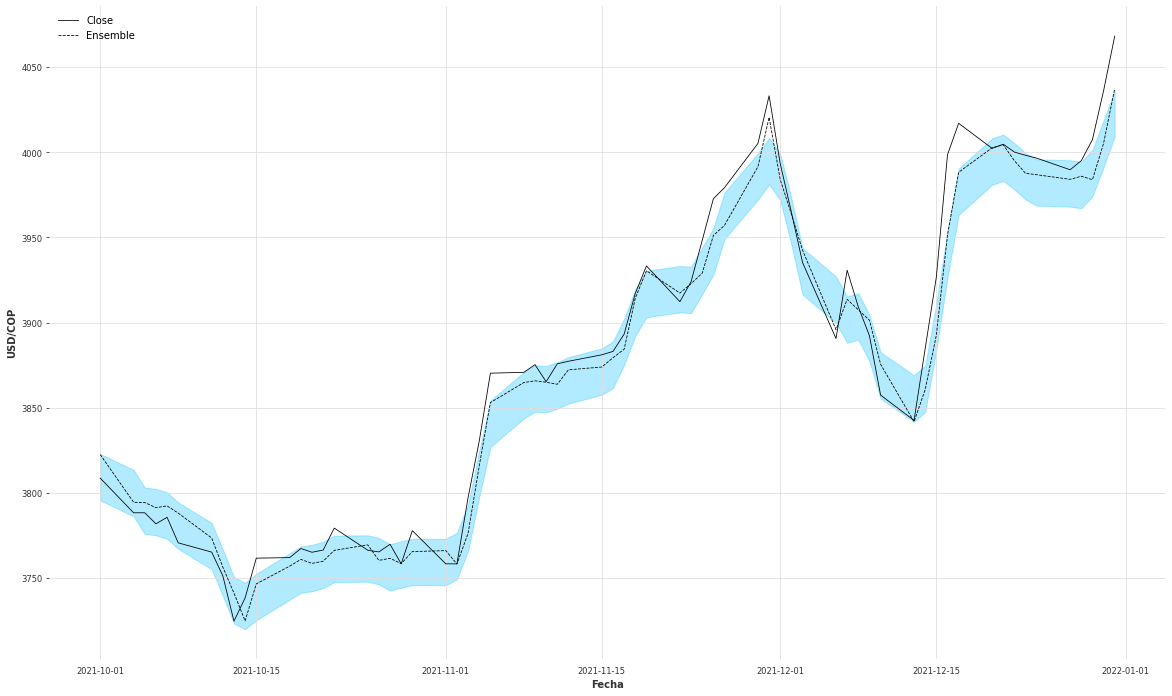

In [194]:
plt.figure(figsize=(20, 12))
plt.plot(best_forecast.index, best_forecast['close'], color = 'black', linewidth=0.8, label = 'Close')
plt.plot(best_forecast.index, best_forecast['Ensemble_forecast'], color = 'black', linewidth=0.8, linestyle = 'dashed', label = 'Ensemble')
plt.fill_between(best_forecast.index, best_forecast['LI'], best_forecast['LS'], color = 'deepskyblue', alpha = 0.3)
plt.xlabel('Fecha')
plt.ylabel('USD/COP')
plt.legend()

# Interval predictions (Stacking)

In [195]:
df = final_output["Stacking_ml_forecast"].T

bts_samples_stack = bts.sample(data=df, n_samples=10000)

means_stack = [np.mean(bts_samples_stack[:, i]) for i in range(bts_samples_stack.shape[1])]
std_stack = [np.std(bts_samples_stack[:, i]) for i in range(bts_samples_stack.shape[1])]

best_forecast["LI_Stacking"] = [m - 3 * s for m, s in zip(means_stack, std_stack)]
best_forecast["LS_Stacking"] = [m + 3 * s for m, s in zip(means_stack, std_stack)]

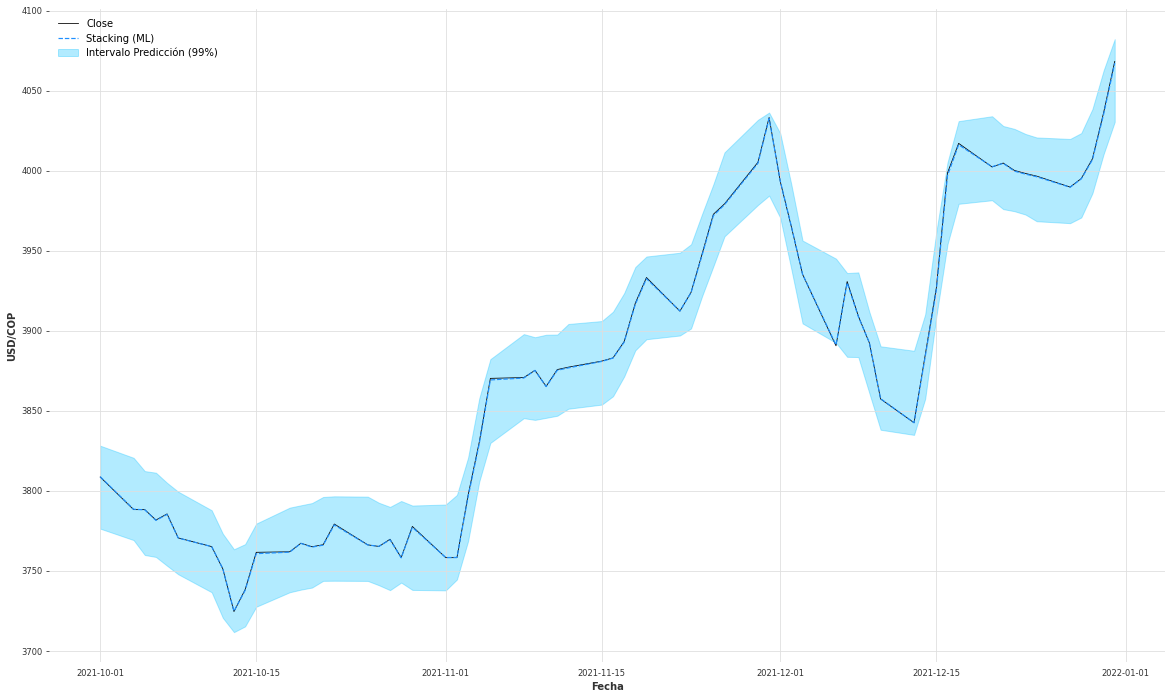

In [196]:
plt.figure(figsize=(20, 12))
plt.plot(best_forecast.index, best_forecast['close'], color = 'black', linewidth=0.8, label = 'Close')
plt.plot(best_forecast.index, best_forecast['Stacking_ml_forecast'], color = 'dodgerblue', linewidth=1.2, linestyle = 'dashed', label = 'Stacking (ML)')
plt.fill_between(best_forecast.index, best_forecast['LI_Stacking'], best_forecast['LS_Stacking'], color = 'deepskyblue', alpha = 0.3, label = 'Intervalo Predicción (99%)')
plt.xlabel('Fecha')
plt.ylabel('USD/COP')
plt.legend()

In [199]:
final_output.to_csv("data/final_output.csv")

In [201]:
train.to_csv("data/train_forecast.csv")

In [204]:
X_train.join(X_train_dl).to_csv("data/X_train_stacking.csv", index=False)
X_test.join(X_test_dl).to_csv("data/X_test_stacking.csv", index=False)